In [1]:
import os
from srs.utilities import Sentence
from srs.maxEntropyModel import load_labelled_sent, loadDynamicAspectList, train, cond_prob
from srs.predictor import StaticPredictor
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline 

## Loading stemmed dynamic aspects

In [2]:
stemmed_dynamic_data_dir = os.path.abspath('../data/word_list/')

stemmed_dynamic_dict = {}
for data_file in os.listdir(stemmed_dynamic_data_dir):
    if data_file.endswith('stemmedwordlist.txt'):
        file_open = open(os.path.join(stemmed_dynamic_data_dir, data_file), 'r')
        stemmed_wordlist = json.load(file_open)
        for sublist in stemmed_wordlist:
            stemmed_dynamic_aspect = sublist[0]
            stemmed_dynamic_aspect_count = sublist[1]
            if stemmed_dynamic_aspect in stemmed_dynamic_dict:
                stemmed_dynamic_dict[stemmed_dynamic_aspect] += stemmed_dynamic_aspect_count
            else:
                stemmed_dynamic_dict[stemmed_dynamic_aspect] = stemmed_dynamic_aspect_count

In [3]:
#sorting
dynamic_tups_sorted = sorted(stemmed_dynamic_dict.items(), key=lambda tup: -tup[1])
dynamic_label_sorted = [tup[0] for tup in dynamic_tups_sorted]
dynamic_count_sorted = [tup[1] for tup in dynamic_tups_sorted]

## Loading training sentences

In [4]:
static_traning_data_dir = os.path.abspath('../srs/static_training_data/')

sentences = []
for data_file in os.listdir(static_traning_data_dir):
    if data_file.endswith('labeled.txt'):
        sentences.extend(load_labelled_sent(os.path.join(static_traning_data_dir, data_file)))

## Statistical analysis on training data

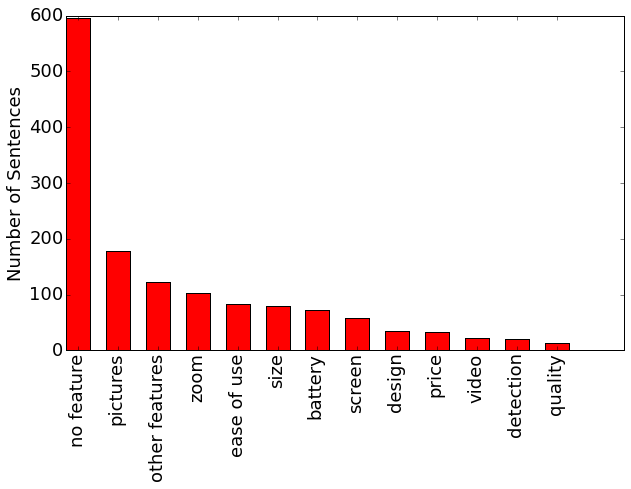

In [5]:
# static aspect counting
static_label_dict = {}
for sentence in sentences:
    if sentence.labeled_aspects not in static_label_dict:
        static_label_dict[sentence.labeled_aspects] = 1
    else:
        static_label_dict[sentence.labeled_aspects] += 1

#sorting
static_label_tups_sorted = sorted(static_label_dict.items(), key=lambda tup: -tup[1])
static_label_sorted = [tup[0] for tup in static_label_tups_sorted]
static_count_sorted = [tup[1] for tup in static_label_tups_sorted]

ind = np.arange(len(static_label_sorted))
width = 0.6
heights = static_count_sorted

plt.figure(figsize=[10,6])
ax = plt.gca()
ax.bar(ind, heights, width, color='r')
ax.set_xticks(ind+width/2)
ticks = ax.set_xticklabels(static_label_sorted, rotation=90)
plt.ylabel(u'Number of Sentences')

# set plotting params
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    

## Predicting

In [6]:
# set up predictor
staticPredictor = StaticPredictor()
params_file = '../srs/predictor_data/lambda_opt.txt'
static_aspect_list_file = '../srs/predictor_data/static_aspect_list.txt'
staticPredictor.loadParams(params_file)
staticPredictor.loadStaticAspectList(static_aspect_list_file)

In [35]:
validation_set = sentences[:]
correct = 0.0
correct_dict = {}
incorrect_dict = {}
expect_dict = {}
for sentence in validation_set:
    predicted_aspect = staticPredictor.predict(sentence, cp_threshold=0)
    if predicted_aspect == sentence.labeled_aspects:
        correct += 1
        if predicted_aspect not in correct_dict:
            correct_dict[predicted_aspect] = [sentence]
        else:
            correct_dict[predicted_aspect].append(sentence)
    else:
        if predicted_aspect not in incorrect_dict:
            incorrect_dict[predicted_aspect] = [sentence]
        else:
            incorrect_dict[predicted_aspect].append(sentence)
        
        if sentence.labeled_aspects not in expect_dict:
            expect_dict[sentence.labeled_aspects] = [sentence]
        else:
            expect_dict[sentence.labeled_aspects].append(sentence)
        

In [40]:
print "Precision:"
print '-----------'
for aspect in correct_dict:
    print aspect
    print len(correct_dict[aspect])*1.0/(len(correct_dict[aspect]) + len(incorrect_dict[aspect]))

Precision:
-----------
battery
0.725490196078
pictures
0.464601769912
screen
0.722222222222
no feature
0.545253863135
zoom
0.718309859155
design
0.666666666667
other features
0.477272727273
ease of use
0.533333333333
price
0.0195599022005
size
0.636363636364


In [41]:
print "Recall:"
print "----------"
for aspect in correct_dict:
    print aspect
    print len(correct_dict[aspect])*1.0/(len(correct_dict[aspect]) + len(expect_dict[aspect]))

Recall:
----------
battery
0.513888888889
pictures
0.589887640449
screen
0.672413793103
no feature
0.41512605042
zoom
0.495145631068
design
0.176470588235
other features
0.341463414634
ease of use
0.0963855421687
price
0.242424242424
size
0.2625


In [43]:
aspect = "price"
print len(correct_dict[aspect]) + len(incorrect_dict[aspect])

409


## Practical scheme summary

In prediction phase, if `max(cp)` is higher than 50%, we choose the static aspect corresponding to `max(cp)`, OTHERWISE, we choose `no feature`, which means we will discard this sentence when doing sentiment analysis.